# Classification for Linear Model
## Logistic Regression

The logistic regression model is a generalization of the linear regression model which we can use when the response variable is binary. This model uses the _logistic function_ as an _inverse link function_:

\begin{equation*}
\text{logistic}(z) = \frac{1}{1+e^{-z}}
\end{equation*}

For our purpose, the key property of the logistic function is that irrespective of the values of its argument $z$, the result will always be a number in the $[0,1]$-interval. Thus, we can see 
this function as a convenient way to compress the values computed from a linear model into values that we can feed into a _Bernoulli distribution_. This logistic function is also known as the sigmoid function because of its characteristic S-shaped aspect.

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Text(0, 0.5, 'logistic(z)')

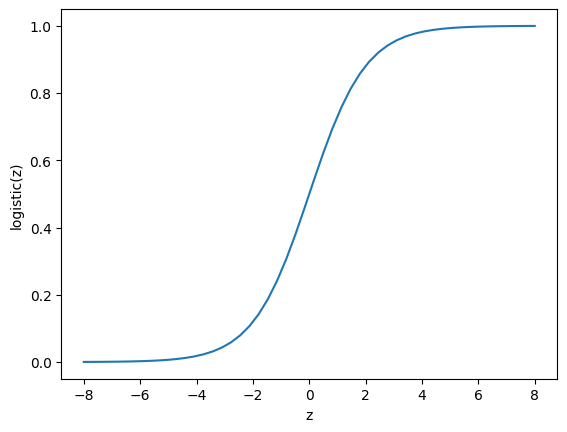

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import pytensor.tensor as pt
from scipy.special import expit as logistic
import pandas as pd
z = np.linspace(-8, 8)
plt.plot(z, 1 / (1 + np.exp(-z)))
plt.xlabel("z")
plt.ylabel("logistic(z)")

### The logistic model

We have almost all the elements to turn a simple linear regression into a simple logistic regression. Let's begin with the case of only two classes, for example ham/spam, safe/unsafe, healthy/ill, cloudy/sunny,... First, we codify these classes by saying that the predicted variable $y$ can only take two values, $0$ or $1$, that is $y\in\{0,1\}$. 

State this way, the problem sounds very similar to the coin-flipping. We may remember we used the Bernoulli distribution as the likelihood. The difference with the coin-flipping problem is that now $\theta$ is not going to be generated from a beta distribution; instead, $\theta$ is going to be defined by a linear model with the logistic as the inverse link function. Omitting the priors, we have:

\begin{align*}
\theta & = \text{logistic}(\alpha +\beta x)\\
y & \sim \text{Bernoulli}(\theta)
\end{align*}

We are going to apply logistic regression to the classic `iris` dataset which has measurements from flowers from three closely related species: `setosa`, `virginica`, and `versicolor`. These measurements are the `petal length`, `petal width`, `sepal length`, and `sepal width`. In case you are wondering, sepals are modified leaves whose function is generally related to protecting the flowers in a bud. 

We are going to begin with a simple case. Let's assume we only have two classes, `setosa`, and `versicolor`, and just one independent variable or feature, `sepal_length`. We want to predict the probability of a flower being `setosa` given its `sepal length`. 

As is usually done, we are going to encode the `setosa` and `versicolor` categories with the numbers $0$ and $1$. Using pandas, we can do the following:

In [2]:
iris = pd.read_csv("Data/iris.csv")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df["species"]).codes
print(y_0[:15])
x_0 = df["sepal_length"].values
x_c = x_0 - x_0.mean()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


As with other linear models, centering can help with the sampling. Now that we have data in the right format, we can finally build the model with PyMC:

In [4]:
with pm.Model() as model_lrs:
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=5)
    μ = α + x_c * β
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    bd = pm.Deterministic("bd", -α / β)
    yl = pm.Bernoulli("yl", p=θ, observed=y_0)
    idata_lrs = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


- `model_lrs` has two deterministic variables: $\theta$ and `bd`
- $\theta$ is the result of applying the logistic function to variable $\mu$ 
- `bd`is the boundary decision which is the value we use to separate classes. 
- Instead of writing the logistic function ourselves, we are using the one provided by PyMC, `pm.math.sigmoid`

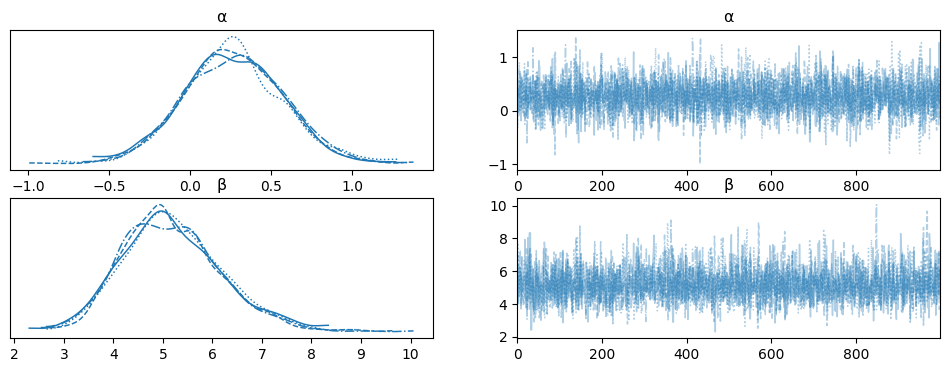

In [5]:
import arviz as az
az.plot_trace(idata_lrs, var_names=["~bd", "~θ"]);

The following figure shows the probability of being `versicolor` $\theta$ versus the `sepal length`.

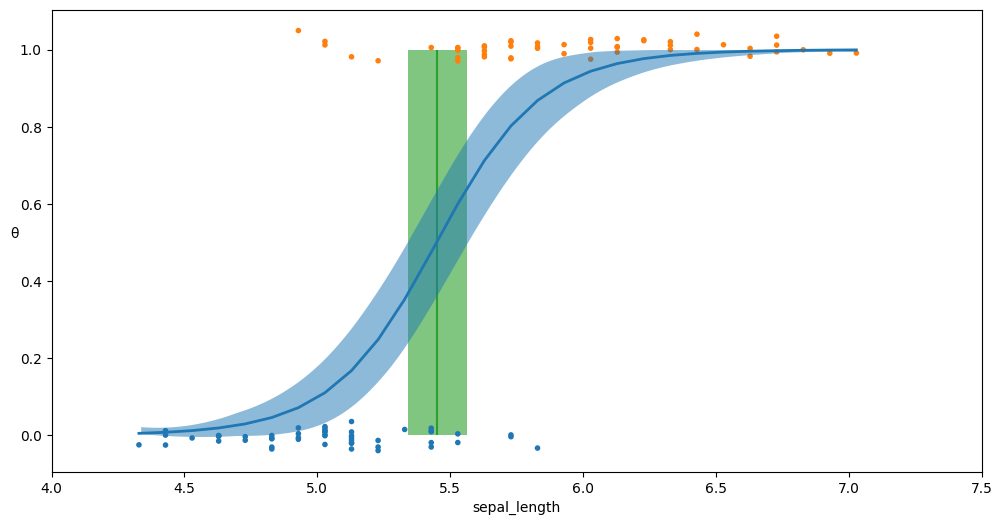

In [6]:
posterior = idata_lrs.posterior
theta = posterior["θ"].mean(("chain", "draw"))
idx = np.argsort(x_c)

_, ax = plt.subplots(figsize=(12, 6))

ax.plot(x_c[idx], theta[idx], color="C0", lw=2)
ax.vlines(posterior["bd"].mean(("chain", "draw")), 0, 1, color="C2", zorder=0)
bd_hdi = az.hdi(posterior["bd"])
ax.fill_betweenx([0, 1], bd_hdi["bd"][0], bd_hdi["bd"][1], color="C2", alpha=0.6, lw=0)
ax.scatter(x_c, np.random.normal(y_0, 0.02), marker=".", color=[f"C{x}" for x in y_0])
az.plot_hdi(x_c, posterior["θ"], color="C0", ax=ax, fill_kwargs={"lw": 0})
ax.set_xlabel("sepal_length")
ax.set_ylabel("θ", rotation=0)
# # use original scale for xticks
locs, _ = plt.xticks()
ax.set_xticks(locs, np.round(locs + x_0.mean(), 1))

- Some jitter (noise) is added to the binary response so the point does not overlap. 
- An S-shaped (blue) line is the mean value of $\theta$. This line can interpreted as the probability of a flower being `versicolor`, given that we know the value of the `sepal length`. 
- The semitransparent S-shaped band is the 94% HDI.
- Logistic regression is a regression method: we are regressing the probability of belonging to some class. For classification, we need a _decision rule_: e.g. we assign the class `versicolor` if $\theta>0.5$ and assign `setosa` otherwise. 
- The vertical is the boundary decision, and it is defined as the value of the predictor variable that makes the probability of being `versicolor` equal to $0.5$. This value is equal to $-\frac{\alpha}{\beta}$
- Because we have uncertainty in the value of $\alpha$ and $\beta$, we also have uncertainty about the value of the boundary decision. This uncertainty is represented as the vertical (gray) band which goes from $\approx 5.3$ to $\approx 5.6$.

# Gaussian Process Classification

In the previous section we saw how a linear model can be used to classify data. We used a Bernoulli likelihood with a _logistic inverse link function_. Then, we applied a boundary decision rule.

In this section, we are going to do the same, but this time using GP instead of a linear model. As we did with `model_lrs`, we are going to use the `iris` dataset with two classes, `setosa` and `versicolor`, and one predictor variable, the `sepal_length`.

In [7]:
df = iris.query("species == ('setosa', 'versicolor')")
y = pd.Categorical(df['species']).codes
x_1 = df['sepal_length'].values
X_1 = x_1[:, None]

In [8]:
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.95, plot=False):
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

In [9]:
with pm.Model() as model_iris:
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(x_1))
    cov = pm.gp.cov.ExpQuad(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    # logistic inverse link function and Bernoulli likelihood
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
    idata_iris = pm.sample(nuts_sampler="nutpie", random_seed=123)

/opt/conda/lib/python3.10/site-packages/pytensor/link/numba/dispatch/basic.py:377: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/pytensor/link/numba/dispatch/basic.py:377: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.48,7
,2000,0,0.49,7
,2000,0,0.48,7
,2000,0,0.49,7


- For this model, we cannot use the `pm.marginal.Marginal` class, because that class is restricted to Gaussian likelihoods as it takes advantage of the mathematical tractability of the combination of a GP prior with a Gaussian likelihood. Instead, we use the more general class `pm.gp.Latent`

In [10]:
X_new = np.linspace(np.floor(x_1.min()), np.ceil(x_1.max()), 200)[:, None]
with model_iris:
    f_pred = gp.conditional('f_pred', X_new) 
    idata_iris_subset = idata_iris.sel(draw=slice(0, None, 100))
    pred_samples = pm.sample_posterior_predictive(idata_iris_subset, var_names=["f_pred"], random_seed=123)


f_pred_iris = (pred_samples.
               posterior_predictive.stack(samples=("chain", "draw"))['f_pred'].
               values)

Sampling: [f_pred]


Output()

/opt/conda/lib/python3.10/site-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(0, 0.5, 'θ')

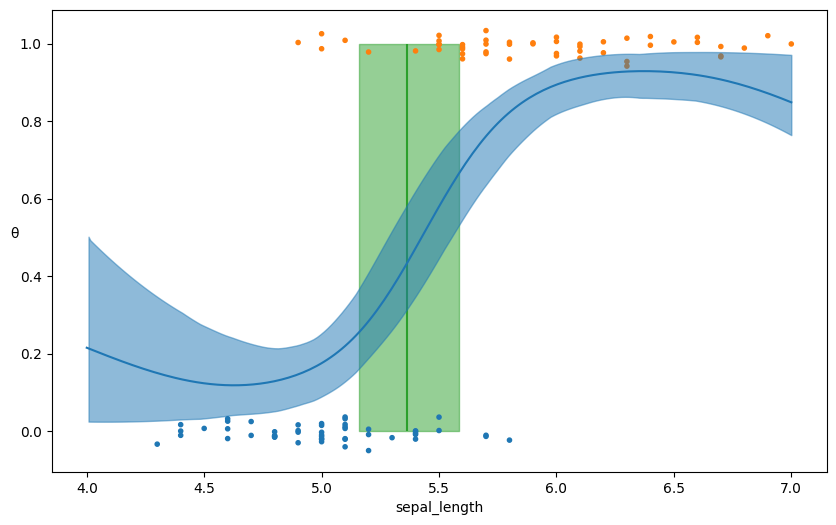

In [11]:
_, ax = plt.subplots(figsize=(10, 6))

fp = logistic(f_pred_iris)
fp_mean = np.mean(fp, 1)

ax.plot(X_new[:, 0], fp_mean)
# plot the data (with some jitter) and the true latent function
ax.scatter(x_1, np.random.normal(y, 0.02),
           marker='.', color=[f'C{x}' for x in y])

az.plot_hdi(X_new[:, 0], fp.T, color='C0')

decision_boundary = 0.5
db = X_new[:,0][np.argmin(np.abs(fp - decision_boundary), 0)]
db_mean = db.mean()
db_hdi = az.hdi(db)
ax.vlines(db_mean, 0, 1, color='C2', zorder=-1)
ax.fill_betweenx([0, 1], db_hdi[0], db_hdi[1], color='C2', alpha=0.5, zorder=-1)
ax.set_xlabel('sepal_length')
ax.set_ylabel('θ', rotation=0)

- The inferred function looks similar to a sigmoid curve, except for the tails that go up at lower values of `sepal_length`, and down at higher values of `sepal_length`. Reason: When there is little or no data available, a GP posterior tends to revert to the GP prior. 
- If the only concern is the decision boundary, then the behavior at the tails may be irrelevant. 
- If we want to model the probabilities of belonging to `setosa`or `versicolor` at different values of `sepal_length`, we should do something to improve the model at the tails.

In [12]:
!pip install nutpie
with pm.Model() as model_iris2:
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(x_1))
    c = pm.Normal('c', x_1.min())
    τ = pm.HalfNormal('τ', 5)
    cov = (pm.gp.cov.ExpQuad(1, ℓ) +
           τ * pm.gp.cov.Linear(1, c) +
           pm.gp.cov.WhiteNoise(1E-5))
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    # logistic inverse link function and Bernoulli likelihood
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
    idata_iris2 = pm.sample(nuts_sampler="nutpie", random_seed=123)

/opt/conda/lib/python3.10/site-packages/pytensor/link/numba/dispatch/basic.py:377: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/pytensor/link/numba/dispatch/basic.py:377: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/pytensor/link/numba/dispatch/basic.py:377: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/pytensor/link/numba/dispatch/basic.py:377: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.37,15
,2000,2,0.38,15
,2000,3,0.37,15
,2000,1,0.38,15


- We combine three kernels: the _exponential quadratic kernel_, a _linear kernel_, and a _white noise kernel_.
- The _linear kernel_ will have the effect of making the tails got to 0 or 1 at the boundaries of the data.
- _White noise kernel_ is used as trick to stabilize the computation of the covariance matrix: Kernels of Gaussian processes are restricted to guarantee the resulting covariance matrix is positive definite. Nevertheless, numerical errors can lead to violating this condition. One manifestation is that we get NaNs when computing posterior predictive samples of the fitted function. One way to mitigate this error is to stabilize the computation by adding some noise. 

In [13]:
with model_iris2:
    f_pred = gp.conditional('f_pred', X_new) 
    idata_iris2_subset = idata_iris2.sel(draw=slice(0, None, 100))
    pred_samples2 = pm.sample_posterior_predictive(idata_iris2_subset,
                                                   var_names=["f_pred"],
                                                   random_seed=123)


f_pred_iris2 = (pred_samples2.
                posterior_predictive.stack(samples=("chain", "draw"))['f_pred'].
                values)      

Sampling: [f_pred]


Output()

/opt/conda/lib/python3.10/site-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(0, 0.5, 'θ')

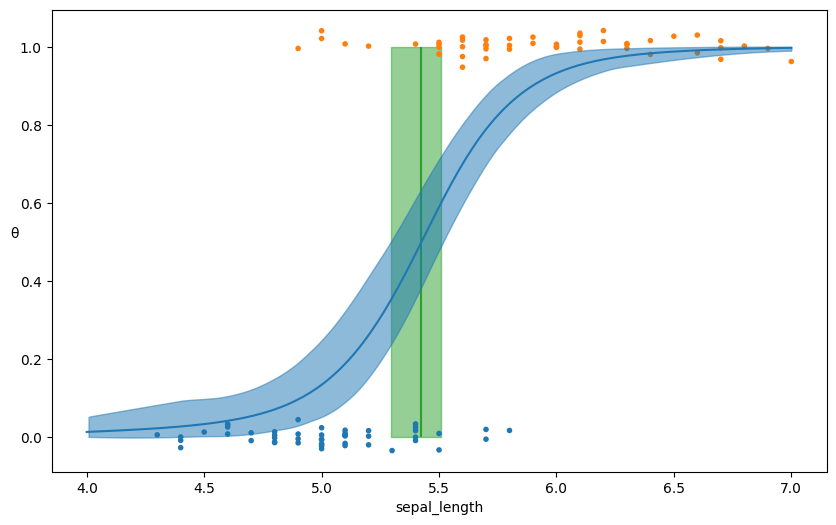

In [14]:
_, ax = plt.subplots(figsize=(10, 6))

fp = logistic(f_pred_iris2)
fp_mean = np.mean(fp, 1)

ax.plot(X_new[:, 0], fp_mean)
# plot the data (with some jitter) and the true latent function
ax.scatter(x_1, np.random.normal(y, 0.02),
           marker='.', color=[f'C{x}' for x in y])

az.plot_hdi(X_new[:, 0], fp.T, color='C0')

decision_boundary = 0.5
db = X_new[:,0][np.argmin(np.abs(fp - decision_boundary), 0)]
db_mean = db.mean()
db_hdi = az.hdi(db)
ax.vlines(db_mean, 0, 1, color='C2', zorder=-1)
ax.fill_betweenx([0, 1], db_hdi[0], db_hdi[1], color='C2', alpha=0.5, zorder=-1)
ax.set_xlabel('sepal_length')
ax.set_ylabel('θ', rotation=0)

The result of this model looks much more similar to the result of the logistic regression model `model_lrs`.